In [1]:
import os
import pathlib
import argparse
import yaml
import timm
import tqdm

import torch
import constants as const
import dataset
import fastflow
import utils
import numpy as np
import itertools

In [2]:
def parse_args(arg_list: list):
    """ArgumentParseインスタンスを作成し，コマンドライン引数を読み込む．
    Returns:
        args
    """
    parser = argparse.ArgumentParser(description="Train FastFlow_org on MVTec-AD dataset")
    parser.add_argument(
        "-cfg", "--config", type=str, required=True, help="path to config file"
    )
    parser.add_argument('--name', type=str, required=True, help='dataset name')
    parser.add_argument("--data", type=str, required=True, help="path to dataset folder")
    parser.add_argument(
        "-cat",
        "--category",
        type=str,
        required=True,
        help="category name in dataset. If 'all' was specified, train FastFlow by using all OK_Clip data",
    )
    parser.add_argument('--valid', type=str, help='validation category')
    parser.add_argument('--color', type=str, choices=['rgb', 'gray'])
    parser.add_argument('-p', '--patchsize', type=int, help='patch size. By default, patch separation will not do')
    parser.add_argument('--random', action='store_true', help='random patch sampling')
    parser.add_argument('--mask', action='store_true', help='target mask')
    parser.add_argument("--eval", action="store_true", help="run eval only")
    parser.add_argument("--post", action='store_true', help='run postprocessing only')
    parser.add_argument(
        "-ckpt", "--checkpoint", type=str, help="path to load checkpoint"
    )
    parser.add_argument("--heatmap", action='store_true', help='saving heatmap on test images')
    parser.add_argument('-t', '--threshold', type=float, help='threshold')

    # 引数のチェック
    dataset_list = ['mvtec', 'jelly', 'package']
    args = parser.parse_args(arg_list)

    assert args.name in dataset_list, f'利用可能なデータセットは{dataset_list}です．'

    if args.name == 'mvtec':
        assert args.category in const.MVTEC_CATEGORIES, f'MVTecにおいて利用可能なクラスは{const.MVTEC_CATEGORIES}です'
    if args.name == 'jelly':
        assert args.category in const.JELLY_CATEGORIES, f'Jellyにおいて利用可能なクラスは{const.JELLY_CATEGORIES}です'

    return args

In [3]:
args_list = [
    '--config', 'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\configs\deit.yaml',
    '--name',
    'package',
    '--data',
    'C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\data\package_square',
    '-cat',
    'cut',
    '--valid',
    'cut'
]
args = parse_args(args_list)

In [4]:
# backboneのメタ情報を読み込み，モデルをビルド
with open(args.config, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
model = fastflow.build_model(config, args)
optimizer = fastflow.build_optimizer(model)

Total model Param#: 122.622372[MB]


In [5]:
# instantiate dataloader and model
train_dataloader = dataset.build_train_data_loader(args, config)
test_dataloader = dataset.build_test_data_loader(args, config)

In [6]:
# instantiate pretrained model
backbone_name = const.BACKBONE_RESNET18
backbone = timm.create_model(backbone_name, pretrained=True, features_only=True, out_indices=[4])
backbone.eval()

FeatureListNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=

In [7]:
def get_embedding(model: torch.nn.Module, batch: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        out = model(batch)[0]
    return out

In [24]:
normal_list = []
backbone = backbone.cuda()
for batch in tqdm.tqdm(train_dataloader):
    batch = batch.cuda()
    outputs = get_embedding(backbone, batch)
    # features = backbone(batch)[0]
    outputs = torch.nn.AvgPool2d(kernel_size=outputs.shape[-2:])(outputs)
    # normal_batch = torch.flatten(outputs, start_dim=1, end_dim=-1)
    # features: (B, C, 1, 1)
    normal_batch = outputs.view(*outputs.shape[:2])
    # convert tensor to Float16
    # normal_batch = normal_batch.to(torch.float16)
    # -> (B, C)
    normal_list.append(normal_batch)

100%|██████████| 1621/1621 [00:19<00:00, 82.14it/s] 


In [25]:
normal_list[0].shape

torch.Size([1, 512])

In [26]:
# -> (num_of_normal_samples, B, C)
normal_embed = torch.stack(normal_list, dim=0).cpu().detach().numpy()

## K-meansのサンプル

In [27]:
class KMeans:
    def __init__(self, n_clusters, max_iter=1000, random_seed=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)

    # X.shape: (N, D)
    def fit(self, X):
        # initialization
        cycle = itertools.cycle(range(self.n_clusters))
        self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
        self.random_state.shuffle(self.labels_)
        labels_prev = np.zeros(X.shape[0])
        count = 0
        self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))

        while (not (self.labels_ == labels_prev).all() and count < self.max_iter):
            for i in tqdm.tqdm(range(self.n_clusters)):
                XX = X[self.labels_ == i, :]
                print(XX.shape)
                self.cluster_centers_[i, :] = XX.mean(axis=0)
            dist = ((X[..., np.newaxis] - self.cluster_centers_.T[np.newaxis, ...]) ** 2).sum(axis=1)
            labels_prev = self.labels_
            self.labels_ = dist.argmin(axis = 1)
            count += 1

    def predict(self, X):
        dist = ((X[:, :, np.newaxis] - self.cluster_centers_.T[np.newaxis, ...]) ** 2).sum(axis = 1)
        labels = dist.argmin(axis = 1)
        return labels

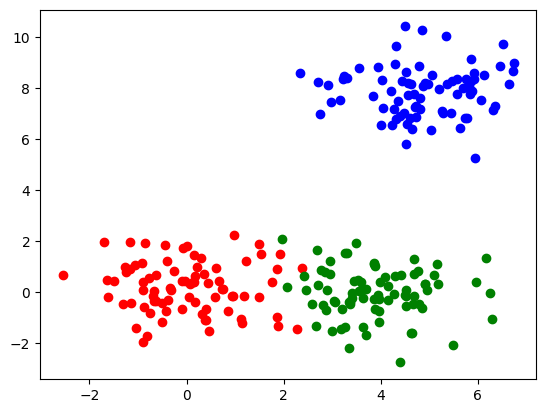

In [28]:
import matplotlib.pyplot as plt
np.random.seed(0)
points1 = np.random.randn(80, 2)  # default cluster
points2 = np.random.randn(80, 2) + np.array([4,0])  # translated_x
points3 = np.random.randn(80, 2) + np.array([5,8])  # translated_x_and_y

points = np.r_[points1, points2, points3]

color = ['r', 'g', 'b']
for i in range(3):
    p = points[80*i:80*(i+1)]
    plt.scatter(p[:, 0], p[:, 1], color = color[i])
plt.show()

In [29]:
np.random.shuffle(points)

model = KMeans(3)
model.fit(points)

print(model.labels_)

C:\Users\s2231\AppData\Local\Temp\ipykernel_12128\1340154803.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
100%|██████████| 3/3 [00:00<?, ?it/s]


(80, 2)
(80, 2)
(80, 2)


100%|██████████| 3/3 [00:00<?, ?it/s]


(78, 2)
(82, 2)
(80, 2)


100%|██████████| 3/3 [00:00<?, ?it/s]

(77, 2)
(83, 2)
(80, 2)
[1 0 2 1 0 0 2 0 1 2 0 0 2 0 2 2 0 0 2 1 2 0 1 2 0 1 2 1 0 1 0 0 0 2 0 2 0
 1 1 0 0 0 0 1 2 0 0 0 2 1 0 2 1 0 2 0 2 1 1 1 1 1 0 2 0 2 2 0 0 0 0 0 2 0
 2 2 2 1 0 2 1 2 0 0 2 0 1 2 1 1 1 2 2 2 1 2 2 2 1 2 1 0 0 0 0 0 2 0 1 0 1
 2 0 1 1 0 1 2 1 1 1 2 2 1 2 1 0 1 1 2 0 1 0 1 1 1 0 2 1 0 0 1 2 2 2 1 0 0
 0 2 2 2 0 0 1 2 0 2 2 2 1 2 2 2 2 2 1 1 0 1 2 1 1 2 0 1 1 1 1 0 2 1 0 1 1
 2 1 2 2 2 1 2 0 1 2 2 2 0 0 0 0 1 1 2 1 1 1 2 2 0 0 1 1 2 0 0 1 0 1 1 2 1
 0 1 2 1 0 1 2 2 1 1 2 1 2 1 0 1 1 2]


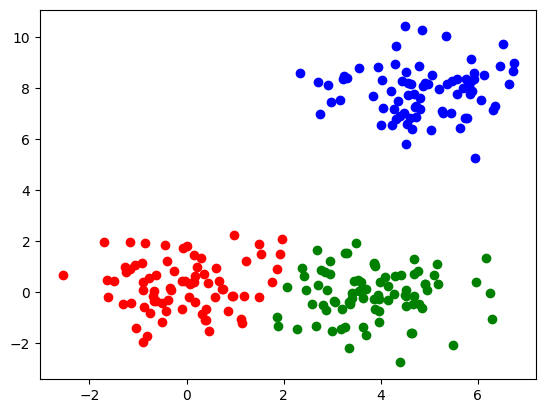

In [30]:
for i in range(3):
    p = points[model.labels_ == i, :]
    plt.scatter(p[:, 0], p[:, 1], color = color[i])
plt.show()

## K-meansによる正常画像のクラスタリング

In [31]:
normal_embed.shape

(1621, 1, 512)

In [32]:
normal_embed = normal_embed.reshape(normal_embed.shape[0] * normal_embed.shape[1], normal_embed.shape[2])
normal_embed.shape

(1621, 512)

In [33]:
K = 5
model = KMeans(K)
model.fit(normal_embed)

C:\Users\s2231\AppData\Local\Temp\ipykernel_12128\1340154803.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels_ = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype=np.int)
100%|██████████| 5/5 [00:00<?, ?it/s]


(325, 512)
(324, 512)
(324, 512)
(324, 512)
(324, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(335, 512)
(365, 512)
(259, 512)
(319, 512)
(343, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(326, 512)
(384, 512)
(323, 512)
(302, 512)
(286, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(320, 512)
(387, 512)
(341, 512)
(304, 512)
(269, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(320, 512)
(388, 512)
(345, 512)
(298, 512)
(270, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(314, 512)
(393, 512)
(349, 512)
(296, 512)
(269, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(311, 512)
(396, 512)
(349, 512)
(290, 512)
(275, 512)


  0%|          | 0/5 [00:00<?, ?it/s]

(303, 512)
(399, 512)
(351, 512)
(293, 512)
(275, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(300, 512)
(402, 512)
(351, 512)
(294, 512)
(274, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(297, 512)
(408, 512)
(354, 512)
(291, 512)
(271, 512)


100%|██████████| 5/5 [00:00<00:00, 622.34it/s]


(298, 512)
(415, 512)
(354, 512)
(283, 512)
(271, 512)


100%|██████████| 5/5 [00:00<00:00, 2445.94it/s]


(297, 512)
(426, 512)
(356, 512)
(273, 512)
(269, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]

(295, 512)
(431, 512)
(358, 512)
(270, 512)
(267, 512)



100%|██████████| 5/5 [00:00<?, ?it/s]


(293, 512)
(430, 512)
(358, 512)
(272, 512)
(268, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(292, 512)
(429, 512)
(358, 512)
(273, 512)
(269, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(292, 512)
(428, 512)
(358, 512)
(273, 512)
(270, 512)


100%|██████████| 5/5 [00:00<00:00, 613.94it/s]


(292, 512)
(427, 512)
(359, 512)
(273, 512)
(270, 512)


100%|██████████| 5/5 [00:00<00:00, 621.58it/s]


(292, 512)
(426, 512)
(360, 512)
(273, 512)
(270, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]


(292, 512)
(425, 512)
(362, 512)
(273, 512)
(269, 512)


100%|██████████| 5/5 [00:00<?, ?it/s]

(292, 512)
(425, 512)
(363, 512)
(272, 512)
(269, 512)


In [34]:
model.labels_

array([3, 2, 2, ..., 1, 0, 3], dtype=int64)

In [35]:
files = train_dataloader.dataset.image_files
file_names = np.array([file.stem for file in files])
file_names

array(['1_Cam1_000597', '2_Cam1_000396', '2_Cam1_000666', ...,
       '1_Cam1_000052', '1_Cam1_000229', '2_Cam1_000691'], dtype='<U13')

In [36]:
img_list = np.array(train_dataloader.dataset.image_files)

In [39]:
index = np.where(model.labels_ == 1)[0]
index

array([  10,   11,   19,   22,   26,   31,   33,   36,   37,   41,   48,
         49,   56,   57,   60,   70,   71,   78,   80,   93,   94,   96,
         98,   99,  102,  103,  108,  110,  114,  119,  121,  122,  129,
        130,  131,  133,  135,  139,  140,  142,  143,  146,  148,  152,
        158,  173,  174,  182,  185,  188,  189,  192,  194,  201,  204,
        206,  211,  212,  214,  220,  221,  227,  231,  238,  239,  240,
        244,  246,  250,  251,  252,  257,  265,  269,  273,  280,  285,
        288,  290,  294,  301,  303,  308,  309,  312,  317,  321,  322,
        324,  327,  328,  330,  332,  334,  337,  338,  340,  341,  344,
        345,  346,  349,  350,  360,  361,  366,  368,  369,  375,  377,
        378,  379,  380,  384,  385,  386,  396,  404,  407,  411,  418,
        425,  427,  432,  433,  438,  442,  443,  455,  456,  459,  480,
        484,  495,  496,  500,  507,  508,  509,  512,  518,  524,  534,
        537,  538,  539,  544,  547,  551,  558,  5

In [40]:
img_list[index]

array([WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000200.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000576.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000113.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000231.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000997.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000539.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000029.jpg'),
       WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFl

In [113]:
train_dataloader.dataset.image_files

[WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/1_Cam1_000597.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000396.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000666.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000578.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000785.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000361.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000445.jpg'),
 WindowsPath('C:/Users/s2231/PycharmProjects/FastFlow/Fast_flow/FastFlow/data/package_square/cut/OK_Clip/2_Cam1_000019

In [118]:
batch = next(iter(train_dataloader))
batch

tensor([[[[-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          ...,
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
          [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],

         [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],

         [[-1.7870, -1.7870, -1.7870,  ..., -1.7870, -1.7870, -1.7870],
          [-1.7870, -1.7870, -

AttributeError: 'PackDataset' object has no attribute 'batch_files'